Note: The project takes a few minutes to load because it needs to download the library and data. If you don't want to wait, feel free to download this .csv file to your Google Drive and grant this colab notebook acess to it down below!



In [45]:
import warnings
warnings.filterwarnings('ignore')

!pip install fastf1 > /dev/null

In [46]:
#library imports
import fastf1
from fastf1 import get_session
from fastf1.core import InvalidSessionError
from datetime import datetime

# data imports
import pandas as pd
import numpy as np
from plotnine import *

# modelling
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV # Regression Models
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer # Pre-process variables

#clustering
from sklearn.neighbors import NearestNeighbors

# performance
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error #model evaluation

# model validation imports
from sklearn.model_selection import train_test_split # simple TT split cv

# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

%matplotlib inline

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Getting and Cleaning Data

If you already have download the data, you can skip this section and scroll to the 'Exploring Data' section and run the commented out cell there

In [48]:
def get_race_data(race, year):
  session = fastf1.get_session(year, race, 'R')
  session.load(telemetry=False)
  print(session.session_info)
  weather_data = session.laps.get_weather_data()
  #print(weather_data)
  laps = session.laps
  laps = laps.reset_index(drop=True)
  weather_data = weather_data.reset_index(drop=True)

  # exclude the 'Time' column from weather data when joining
  race_data = pd.concat([laps, weather_data.loc[:, ~(weather_data.columns == 'Time')]], axis=1)
  race_data['Year'] = year
  race_data['Event'] = session.session_info['Meeting']['Name']
  return race_data

def get_races_data(year):
  races = []
  for race in range(1, 23):  # Assuming maximum of 22 races in a season
    try:
      races.append(get_race_data(race, year))
    except InvalidSessionError:
      break
  return races

def get_track_data(df):
  tracks_means = df.groupby(['Event'], as_index=False)[continuous].mean()
  tracks_means.rename(columns = new_col_names(continuous, 'mean'), inplace = True)

  tracks_medians = df.groupby(['Event'], as_index=False)[continuous].median()
  tracks_medians.rename(columns = new_col_names(continuous, 'median'), inplace = True)

  tracks_mins = df.groupby(['Event'], as_index=False)[continuous].min()
  tracks_mins.rename(columns = new_col_names(continuous, 'min'), inplace = True)

  tracks_maxs = df.groupby(['Event'], as_index=False)[continuous].max()
  tracks_maxs.rename(columns = new_col_names(continuous, 'max'), inplace = True)

  tracks_stds = df.groupby(['Event'], as_index=False)[continuous].std()
  tracks_stds.rename(columns = new_col_names(continuous, 'std'), inplace = True)

  return tracks_means, tracks_medians, tracks_mins, tracks_maxs, tracks_stds

def new_col_names(cols, metric):
  changes = {}
  for col in cols:
    changes[col] = col + '_' + metric
  return changes

###Data for all 2023 Formula 1 Races

In [88]:
# Initialize an empty list to store race data
races_data_copy = pd.concat(get_races_data(2023))
races_data = races_data_copy

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

{'Meeting': {'Key': 1141, 'Name': 'Bahrain Grand Prix', 'OfficialName': 'FORMULA 1 GULF AIR BAHRAIN GRAND PRIX 2023', 'Location': 'Sakhir', 'Country': {'Key': 36, 'Code': 'BRN', 'Name': 'Bahrain'}, 'Circuit': {'Key': 63, 'ShortName': 'Sakhir'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 7953, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 3, 5, 18, 0), 'EndDate': datetime.datetime(2023, 3, 5, 20, 0), 'GmtOffset': datetime.timedelta(seconds=10800), 'Path': '2023/2023-03-05_Bahrain_Grand_Prix/2023-03-05_Race/'}


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Saudi Arabian Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
c

{'Meeting': {'Key': 1142, 'Name': 'Saudi Arabian Grand Prix', 'OfficialName': 'FORMULA 1 STC SAUDI ARABIAN GRAND PRIX 2023', 'Location': 'Jeddah', 'Country': {'Key': 153, 'Code': 'KSA', 'Name': 'Saudi Arabia'}, 'Circuit': {'Key': 149, 'ShortName': 'Jeddah'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 7779, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 3, 19, 20, 0), 'EndDate': datetime.datetime(2023, 3, 19, 22, 0), 'GmtOffset': datetime.timedelta(seconds=10800), 'Path': '2023/2023-03-19_Saudi_Arabian_Grand_Prix/2023-03-19_Race/'}


core           INFO 	Loading data for Australian Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core   

{'Meeting': {'Key': 1143, 'Name': 'Australian Grand Prix', 'OfficialName': 'FORMULA 1 ROLEX AUSTRALIAN GRAND PRIX 2023', 'Location': 'Melbourne', 'Country': {'Key': 5, 'Code': 'AUS', 'Name': 'Australia'}, 'Circuit': {'Key': 10, 'ShortName': 'Melbourne'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 7787, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 4, 2, 15, 0), 'EndDate': datetime.datetime(2023, 4, 2, 17, 0), 'GmtOffset': datetime.timedelta(seconds=36000), 'Path': '2023/2023-04-02_Australian_Grand_Prix/2023-04-02_Race/'}


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 791, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 537, in _make_request
    response = conn.getresponse()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 461, in getresponse
    httplib_response = super().getresponse()
  File "/usr/lib/python3.10/http/client.py", line 1375, in getresponse
    response.begin()
  File "/usr/lib/python3.10/http/client.py", line 318, in begin
    version, stat

{'Meeting': {'Key': 1207, 'Name': 'Azerbaijan Grand Prix', 'OfficialName': 'FORMULA 1 AZERBAIJAN GRAND PRIX 2023', 'Location': 'Baku', 'Country': {'Key': 30, 'Code': 'AZE', 'Name': 'Azerbaijan'}, 'Circuit': {'Key': 144, 'ShortName': 'Baku'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9070, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 4, 30, 15, 0), 'EndDate': datetime.datetime(2023, 4, 30, 17, 0), 'GmtOffset': datetime.timedelta(seconds=14400), 'Path': '2023/2023-04-30_Azerbaijan_Grand_Prix/2023-04-30_Race/'}


core           INFO 	Loading data for Miami Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Miami Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           IN

{'Meeting': {'Key': 1208, 'Name': 'Miami Grand Prix', 'OfficialName': 'FORMULA 1 CRYPTO.COM MIAMI GRAND PRIX 2023', 'Location': 'Miami', 'Country': {'Key': 19, 'Code': 'USA', 'Name': 'United States'}, 'Circuit': {'Key': 151, 'ShortName': 'Miami'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9078, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 5, 7, 15, 30), 'EndDate': datetime.datetime(2023, 5, 7, 17, 30), 'GmtOffset': datetime.timedelta(days=-1, seconds=72000), 'Path': '2023/2023-05-07_Miami_Grand_Prix/2023-05-07_Race/'}


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           

{'Meeting': {'Key': 1210, 'Name': 'Monaco Grand Prix', 'OfficialName': 'FORMULA 1 GRAND PRIX DE MONACO 2023', 'Location': 'Monaco', 'Country': {'Key': 114, 'Code': 'MON', 'Name': 'Monaco'}, 'Circuit': {'Key': 22, 'ShortName': 'Monte Carlo'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9094, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 5, 28, 15, 0), 'EndDate': datetime.datetime(2023, 5, 28, 17, 0), 'GmtOffset': datetime.timedelta(seconds=7200), 'Path': '2023/2023-05-28_Monaco_Grand_Prix/2023-05-28_Race/'}


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Spanish Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

{'Meeting': {'Key': 1211, 'Name': 'Spanish Grand Prix', 'OfficialName': 'FORMULA 1 AWS GRAN PREMIO DE ESPAÑA 2023', 'Location': 'Barcelona', 'Country': {'Key': 1, 'Code': 'ESP', 'Name': 'Spain'}, 'Circuit': {'Key': 15, 'ShortName': 'Catalunya'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9102, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 6, 4, 15, 0), 'EndDate': datetime.datetime(2023, 6, 4, 17, 0), 'GmtOffset': datetime.timedelta(seconds=7200), 'Path': '2023/2023-06-04_Spanish_Grand_Prix/2023-06-04_Race/'}


core           INFO 	Loading data for Canadian Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Canadian Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 791, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 537, in _make_request
    response = conn.getresponse()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 461, in getresponse
    httplib_response = super().getresponse()
  File "/usr/lib/python3.10/http/client.py", line 1375, in getresponse
    response.begin()
  File "/usr/lib/python3.10/http/client.py", line 318, in begin
    version, status, 

{'Meeting': {'Key': 1212, 'Name': 'Canadian Grand Prix', 'OfficialName': 'FORMULA 1 PIRELLI GRAND PRIX DU CANADA 2023', 'Location': 'Montréal', 'Country': {'Key': 46, 'Code': 'CAN', 'Name': 'Canada'}, 'Circuit': {'Key': 23, 'ShortName': 'Montreal'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9110, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 6, 18, 14, 0), 'EndDate': datetime.datetime(2023, 6, 18, 16, 0), 'GmtOffset': datetime.timedelta(days=-1, seconds=72000), 'Path': '2023/2023-06-18_Canadian_Grand_Prix/2023-06-18_Race/'}


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Austrian Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core       

{'Meeting': {'Key': 1213, 'Name': 'Austrian Grand Prix', 'OfficialName': 'FORMULA 1 ROLEX GROSSER PREIS VON ÖSTERREICH 2023', 'Location': 'Spielberg', 'Country': {'Key': 17, 'Code': 'AUT', 'Name': 'Austria'}, 'Circuit': {'Key': 19, 'ShortName': 'Spielberg'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9118, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 7, 2, 15, 0), 'EndDate': datetime.datetime(2023, 7, 2, 17, 0), 'GmtOffset': datetime.timedelta(seconds=7200), 'Path': '2023/2023-07-02_Austrian_Grand_Prix/2023-07-02_Race/'}


core           INFO 	Loading data for British Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

{'Meeting': {'Key': 1214, 'Name': 'British Grand Prix', 'OfficialName': 'FORMULA 1 ARAMCO BRITISH GRAND PRIX 2023', 'Location': 'Silverstone', 'Country': {'Key': 2, 'Code': 'GBR', 'Name': 'Great Britain'}, 'Circuit': {'Key': 2, 'ShortName': 'Silverstone'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9126, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 7, 9, 15, 0), 'EndDate': datetime.datetime(2023, 7, 9, 17, 0), 'GmtOffset': datetime.timedelta(seconds=3600), 'Path': '2023/2023-07-09_British_Grand_Prix/2023-07-09_Race/'}


core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Hungarian Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

{'Meeting': {'Key': 1215, 'Name': 'Hungarian Grand Prix', 'OfficialName': 'FORMULA 1 QATAR AIRWAYS HUNGARIAN GRAND PRIX 2023', 'Location': 'Budapest', 'Country': {'Key': 14, 'Code': 'HUN', 'Name': 'Hungary'}, 'Circuit': {'Key': 4, 'ShortName': 'Hungaroring'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9133, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 7, 23, 15, 0), 'EndDate': datetime.datetime(2023, 7, 23, 17, 0), 'GmtOffset': datetime.timedelta(seconds=7200), 'Path': '2023/2023-07-23_Hungarian_Grand_Prix/2023-07-23_Race/'}


core           INFO 	Loading data for Belgian Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Belgian Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

{'Meeting': {'Key': 1216, 'Name': 'Belgian Grand Prix', 'OfficialName': 'FORMULA 1 MSC CRUISES BELGIAN GRAND PRIX 2023', 'Location': 'Spa-Francorchamps', 'Country': {'Key': 16, 'Code': 'BEL', 'Name': 'Belgium'}, 'Circuit': {'Key': 7, 'ShortName': 'Spa-Francorchamps'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9141, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 7, 30, 15, 0), 'EndDate': datetime.datetime(2023, 7, 30, 17, 0), 'GmtOffset': datetime.timedelta(seconds=7200), 'Path': '2023/2023-07-30_Belgian_Grand_Prix/2023-07-30_Race/'}


core           INFO 	Loading data for Dutch Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Dutch Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           IN

{'Meeting': {'Key': 1217, 'Name': 'Dutch Grand Prix', 'OfficialName': 'FORMULA 1 HEINEKEN DUTCH GRAND PRIX 2023', 'Location': 'Zandvoort', 'Country': {'Key': 133, 'Code': 'NED', 'Name': 'Netherlands'}, 'Circuit': {'Key': 55, 'ShortName': 'Zandvoort'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9149, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 8, 27, 15, 0), 'EndDate': datetime.datetime(2023, 8, 27, 17, 0), 'GmtOffset': datetime.timedelta(seconds=7200), 'Path': '2023/2023-08-27_Dutch_Grand_Prix/2023-08-27_Race/'}


core           INFO 	Loading data for Italian Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Italian Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

{'Meeting': {'Key': 1218, 'Name': 'Italian Grand Prix', 'OfficialName': 'FORMULA 1 PIRELLI GRAN PREMIO D’ITALIA 2023 ', 'Location': 'Monza', 'Country': {'Key': 13, 'Code': 'ITA', 'Name': 'Italy'}, 'Circuit': {'Key': 39, 'ShortName': 'Monza'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9157, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 9, 3, 15, 0), 'EndDate': datetime.datetime(2023, 9, 3, 17, 0), 'GmtOffset': datetime.timedelta(seconds=7200), 'Path': '2023/2023-09-03_Italian_Grand_Prix/2023-09-03_Race/'}


core           INFO 	Loading data for Singapore Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Singapore Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

{'Meeting': {'Key': 1219, 'Name': 'Singapore Grand Prix', 'OfficialName': 'FORMULA 1 SINGAPORE AIRLINES SINGAPORE GRAND PRIX 2023 ', 'Location': 'Marina Bay', 'Country': {'Key': 157, 'Code': 'SGP', 'Name': 'Singapore'}, 'Circuit': {'Key': 61, 'ShortName': 'Singapore'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9165, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 9, 17, 20, 0), 'EndDate': datetime.datetime(2023, 9, 17, 22, 0), 'GmtOffset': datetime.timedelta(seconds=28800), 'Path': '2023/2023-09-17_Singapore_Grand_Prix/2023-09-17_Race/'}


core           INFO 	Loading data for Japanese Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Japanese Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core       

{'Meeting': {'Key': 1220, 'Name': 'Japanese Grand Prix', 'OfficialName': 'FORMULA 1 LENOVO JAPANESE GRAND PRIX 2023 ', 'Location': 'Suzuka', 'Country': {'Key': 4, 'Code': 'JPN', 'Name': 'Japan'}, 'Circuit': {'Key': 46, 'ShortName': 'Suzuka'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9173, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 9, 24, 14, 0), 'EndDate': datetime.datetime(2023, 9, 24, 16, 0), 'GmtOffset': datetime.timedelta(seconds=32400), 'Path': '2023/2023-09-24_Japanese_Grand_Prix/2023-09-24_Race/'}


core           INFO 	Loading data for Qatar Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Qatar Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           IN

{'Meeting': {'Key': 1221, 'Name': 'Qatar Grand Prix', 'OfficialName': 'FORMULA 1 QATAR AIRWAYS QATAR GRAND PRIX 2023', 'Location': 'Lusail', 'Country': {'Key': 149, 'Code': 'QAT', 'Name': 'Qatar'}, 'Circuit': {'Key': 150, 'ShortName': 'Lusail'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9221, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 10, 8, 20, 0), 'EndDate': datetime.datetime(2023, 10, 8, 22, 0), 'GmtOffset': datetime.timedelta(seconds=10800), 'Path': '2023/2023-10-08_Qatar_Grand_Prix/2023-10-08_Race/'}


core           INFO 	Loading data for United States Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for United States Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
c

{'Meeting': {'Key': 1222, 'Name': 'United States Grand Prix', 'OfficialName': 'FORMULA 1 LENOVO UNITED STATES GRAND PRIX 2023', 'Location': 'Austin', 'Country': {'Key': 19, 'Code': 'USA', 'Name': 'United States'}, 'Circuit': {'Key': 9, 'ShortName': 'Austin'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9213, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 10, 22, 14, 0), 'EndDate': datetime.datetime(2023, 10, 22, 16, 0), 'GmtOffset': datetime.timedelta(days=-1, seconds=68400), 'Path': '2023/2023-10-22_United_States_Grand_Prix/2023-10-22_Race/'}


core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Mexico City Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core 

{'Meeting': {'Key': 1223, 'Name': 'Mexico City Grand Prix', 'OfficialName': 'FORMULA 1 GRAN PREMIO DE LA CIUDAD DE MÉXICO 2023', 'Location': 'Mexico City', 'Country': {'Key': 8, 'Code': 'MEX', 'Name': 'Mexico'}, 'Circuit': {'Key': 65, 'ShortName': 'Mexico City'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9181, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 10, 29, 14, 0), 'EndDate': datetime.datetime(2023, 10, 29, 16, 0), 'GmtOffset': datetime.timedelta(days=-1, seconds=64800), 'Path': '2023/2023-10-29_Mexico_City_Grand_Prix/2023-10-29_Race/'}


core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for São Paulo Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

{'Meeting': {'Key': 1224, 'Name': 'São Paulo Grand Prix', 'OfficialName': 'FORMULA 1 ROLEX GRANDE PRÊMIO DE SÃO PAULO 2023', 'Location': 'São Paulo', 'Country': {'Key': 10, 'Code': 'BRA', 'Name': 'Brazil'}, 'Circuit': {'Key': 14, 'ShortName': 'Interlagos'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9205, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 11, 5, 14, 0), 'EndDate': datetime.datetime(2023, 11, 5, 16, 0), 'GmtOffset': datetime.timedelta(days=-1, seconds=75600), 'Path': '2023/2023-11-05_São_Paulo_Grand_Prix/2023-11-05_Race/'}


core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Las Vegas Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

{'Meeting': {'Key': 1225, 'Name': 'Las Vegas Grand Prix', 'OfficialName': 'FORMULA 1 HEINEKEN SILVER LAS VEGAS GRAND PRIX 2023', 'Location': 'Las Vegas', 'Country': {'Key': 19, 'Code': 'USA', 'Name': 'United States'}, 'Circuit': {'Key': 152, 'ShortName': 'Las Vegas'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9189, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 11, 18, 22, 0), 'EndDate': datetime.datetime(2023, 11, 19, 0, 0), 'GmtOffset': datetime.timedelta(days=-1, seconds=57600), 'Path': '2023/2023-11-18_Las_Vegas_Grand_Prix/2023-11-18_Race/'}


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Abu Dhabi Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

{'Meeting': {'Key': 1226, 'Name': 'Abu Dhabi Grand Prix', 'OfficialName': 'FORMULA 1 ETIHAD AIRWAYS ABU DHABI GRAND PRIX 2023 ', 'Location': 'Yas Island', 'Country': {'Key': 21, 'Code': 'UAE', 'Name': 'United Arab Emirates'}, 'Circuit': {'Key': 70, 'ShortName': 'Yas Marina Circuit'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9197, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 11, 26, 17, 0), 'EndDate': datetime.datetime(2023, 11, 26, 19, 0), 'GmtOffset': datetime.timedelta(seconds=14400), 'Path': '2023/2023-11-26_Abu_Dhabi_Grand_Prix/2023-11-26_Race/'}


###Data for 2023 Japanese Grand Prix

In [89]:
japanese_gp_2023_copy = get_race_data('Suzuka', 2023)
japanese_gp_2023 = japanese_gp_2023_copy

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Japanese Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core       

{'Meeting': {'Key': 1220, 'Name': 'Japanese Grand Prix', 'OfficialName': 'FORMULA 1 LENOVO JAPANESE GRAND PRIX 2023 ', 'Location': 'Suzuka', 'Country': {'Key': 4, 'Code': 'JPN', 'Name': 'Japan'}, 'Circuit': {'Key': 46, 'ShortName': 'Suzuka'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9173, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2023, 9, 24, 14, 0), 'EndDate': datetime.datetime(2023, 9, 24, 16, 0), 'GmtOffset': datetime.timedelta(seconds=32400), 'Path': '2023/2023-09-24_Japanese_Grand_Prix/2023-09-24_Race/'}


###Data for 2024 Japanese Grand Prix

In [90]:
japanese_gp_2024_copy = get_race_data('Suzuka', 2024)
japanese_gp_2024 = japanese_gp_2024_copy

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Japanese Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core       

{'Meeting': {'Key': 1232, 'Name': 'Japanese Grand Prix', 'OfficialName': 'FORMULA 1 MSC CRUISES JAPANESE GRAND PRIX 2024', 'Location': 'Suzuka', 'Country': {'Key': 4, 'Code': 'JPN', 'Name': 'Japan'}, 'Circuit': {'Key': 46, 'ShortName': 'Suzuka'}}, 'ArchiveStatus': {'Status': 'Generating'}, 'Key': 9496, 'Type': 'Race', 'Name': 'Race', 'StartDate': datetime.datetime(2024, 4, 7, 14, 0), 'EndDate': datetime.datetime(2024, 4, 7, 16, 0), 'GmtOffset': datetime.timedelta(seconds=32400), 'Path': '2024/2024-04-07_Japanese_Grand_Prix/2024-04-07_Race/'}


In [91]:
jpn_2 = japanese_gp_2024

##Cleaning

In [92]:
#https://stackoverflow.com/questions/21414639/convert-timedelta-to-floating-point
def convert_timedelta_to_seconds(df):
    for column in df.select_dtypes(include=['timedelta64']):
        df[column] = df[column].dt.total_seconds()
    return df

def clean_df(race_data):
  race_data = race_data.loc[race_data['IsAccurate'] == True]
  race_data = race_data.loc[race_data['FastF1Generated'] == False]
  race_data = race_data.loc[race_data['Deleted'] == False]
  #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
  race_data = race_data.drop(columns=['LapStartDate','PitInTime', 'PitOutTime','DeletedReason','IsAccurate','FastF1Generated',
                                      'Deleted','Sector1SessionTime','Sector2SessionTime','Sector3SessionTime','LapStartTime'])
  #https://stackoverflow.com/questions/15891038/change-column-type-in-pandas
  race_data[['AirTemp', 'Humidity','Pressure','TrackTemp','WindDirection','WindSpeed']] = race_data[['AirTemp','Humidity','Pressure','TrackTemp','WindDirection','WindSpeed']].apply(pd.to_numeric)
  race_data = race_data.astype({'Rainfall': bool})

  race_data.dropna(inplace = True)

  # Convert timedelta64 columns to seconds
  race_data = convert_timedelta_to_seconds(race_data)

  return race_data

In [93]:
races_data_copy = clean_df(races_data_copy)
japanese_gp_2023_copy = clean_df(japanese_gp_2023_copy)
japanese_gp_2024_copy = clean_df(japanese_gp_2024_copy)


races_data = clean_df(races_data)
japanese_gp_2023 = clean_df(japanese_gp_2023)
japanese_gp_2024 = clean_df(japanese_gp_2024)

#Exploring Data

In [94]:
# If you download the data, replace PATH with where each file is located
# Then, uncomment and run this cell
# races_data = pd.read_csv('/content/drive/PATH')
# japanese_gp_2023 = pd.read_csv('/content/drive/PATH')
# japanese_gp_2024 = pd.read_csv('/content/drive/PATH')
# tracks = pd.read_csv('/content/drive/PATH')
# suzuka_2024 = pd.read_csv('/content/drive/PATH')

In [95]:
races_data.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,...,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Year,Event
1,3953.935,VER,1,97.974,2.0,1.0,31.342,42.504,24.128,227.0,...,1.0,27.3,22.0,1016.7,False,31.1,208,0.0,2023,Bahrain Grand Prix
3,4149.917,VER,1,97.976,4.0,1.0,31.271,42.642,24.063,228.0,...,1.0,27.3,22.0,1016.7,False,31.2,204,0.4,2023,Bahrain Grand Prix
5,4345.938,VER,1,97.986,6.0,1.0,31.341,42.632,24.013,229.0,...,1.0,27.1,22.0,1016.9,False,31.0,175,0.6,2023,Bahrain Grand Prix
6,4443.959,VER,1,98.021,7.0,1.0,31.290,42.763,23.968,230.0,...,1.0,27.1,22.0,1016.9,False,30.9,210,0.6,2023,Bahrain Grand Prix
11,4935.834,VER,1,98.591,12.0,1.0,31.408,42.951,24.232,231.0,...,1.0,27.1,21.0,1016.9,False,30.6,179,0.8,2023,Bahrain Grand Prix


In [96]:
japanese_gp_2023.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,...,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Year,Event
4,4506.422,VER,1,96.748,5.0,1.0,34.900,42.960,18.888,276.0,...,1.0,27.2,43.0,1013.0,False,42.6,133,2.0,2023,Japanese Grand Prix
5,4604.259,VER,1,97.837,6.0,1.0,35.176,43.659,19.002,274.0,...,1.0,27.2,42.0,1012.9,False,43.0,130,3.0,2023,Japanese Grand Prix
6,4702.292,VER,1,98.033,7.0,1.0,35.395,43.518,19.120,277.0,...,1.0,27.1,42.0,1013.0,False,42.8,79,1.3,2023,Japanese Grand Prix
8,4898.681,VER,1,98.241,9.0,1.0,35.535,43.764,18.942,275.0,...,1.0,27.1,41.0,1012.9,False,43.0,9,1.7,2023,Japanese Grand Prix
9,4996.982,VER,1,98.301,10.0,1.0,35.544,43.760,18.997,274.0,...,1.0,27.1,40.0,1012.9,False,43.5,155,1.5,2023,Japanese Grand Prix


In [97]:
japanese_gp_2024.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,...,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Year,Event
3,5871.980,VER,1,96.472,4.0,2.0,34.772,43.042,18.658,278.0,...,1.0,22.5,37.0,1012.2,False,39.0,216,3.1,2024,Japanese Grand Prix
4,5968.417,VER,1,96.437,5.0,2.0,34.690,43.035,18.712,279.0,...,1.0,22.5,38.0,1012.3,False,39.0,195,3.0,2024,Japanese Grand Prix
5,6065.272,VER,1,96.855,6.0,2.0,34.965,43.196,18.694,278.0,...,1.0,22.5,39.0,1012.2,False,38.8,201,3.1,2024,Japanese Grand Prix
9,6454.339,VER,1,97.590,10.0,2.0,35.450,43.353,18.787,277.0,...,1.0,22.2,39.0,1012.3,False,39.0,196,3.2,2024,Japanese Grand Prix
10,6552.113,VER,1,97.774,11.0,2.0,35.320,43.622,18.832,276.0,...,1.0,22.1,38.0,1012.3,False,38.5,199,2.6,2024,Japanese Grand Prix


##Deriving New Data

In [98]:
continuous = ['LapTime','Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1',
              'SpeedI2','SpeedFL', 'SpeedST','TyreLife','AirTemp', 'Humidity',
              'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']

In [99]:
track_metrics = get_track_data(races_data)
tracks = track_metrics[0]
for i in range(1,5):
  # Similar to what I did combining lap and weather data
  track_metric = track_metrics[i]
  tracks = pd.concat([tracks, track_metric.loc[:, ~(track_metric.columns == 'Event')]], axis=1)

In [100]:
suzuka_2024_metrics = get_track_data(japanese_gp_2024)
suzuka_2024 = suzuka_2024_metrics[0]
for i in range(1,5):
  # Similar to what I did earlier combining lap and weather data
  track_metric = suzuka_2024_metrics[i]
  suzuka_2024 = pd.concat([suzuka_2024, track_metric.loc[:, ~(track_metric.columns == 'Event')]], axis=1)

#Question 1
Can we predict performance for the 2024 Japanese Grand Prix using only the data from the 2023 Japanese Grand Prix?

In [101]:
japanese_gp_2023.describe()

,Time,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL,SpeedST,TyreLife,Position,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,WindSpeed,Year
count,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.0
mean,6792.810412,98.771599,27.604736,2.296903,35.762129,43.958554,19.050916,274.245902,299.442623,255.078324,297.078324,10.244080,8.495446,27.260291,42.400729,1012.854827,39.868670,123.424408,1.426230,2023.0
std,1465.152006,1.679917,14.656357,0.833387,0.602767,1.112892,0.383154,3.671205,2.696795,5.191872,5.668718,5.638323,4.775859,0.102828,2.160461,0.110735,2.671136,71.163020,0.536517,0.0
min,4506.422000,94.183000,5.000000,1.000000,33.720000,42.118000,18.345000,262.000000,284.000000,147.000000,251.000000,2.000000,1.000000,27.000000,39.000000,1012.700000,36.300000,3.000000,0.500000,2023.0
25%,5553.081000,97.860000,15.000000,2.000000,35.352000,43.560000,18.873000,272.000000,298.000000,254.000000,295.000000,6.000000,4.000000,27.200000,41.000000,1012.700000,37.300000,85.000000,1.000000,2023.0
50%,6749.720000,98.643000,27.000000,2.000000,35.725000,43.888000,19.023000,275.000000,299.000000,255.000000,298.000000,9.000000,8.000000,27.300000,42.000000,1012.900000,39.100000,114.000000,1.300000,2023.0
75%,8103.674000,99.752000,41.000000,3.000000,36.231000,44.287000,19.169000,277.000000,301.000000,257.000000,300.000000,14.000000,12.000000,27.300000,44.000000,1012.900000,42.800000,140.000000,1.700000,2023.0
max,9325.743000,122.755000,53.000000,4.000000,37.636000,66.534000,24.460000,283.000000,314.000000,266.000000,312.000000,29.000000,20.000000,27.500000,47.000000,1013.000000,43.500000,353.000000,3.000000,2023.0


If you look at the mean LapTime, mean AirTemp, and mean TrackTemp, there are astute noticeable differences. The goal would be understand whether these temperature differences can be used to predict the 2024 lap times.

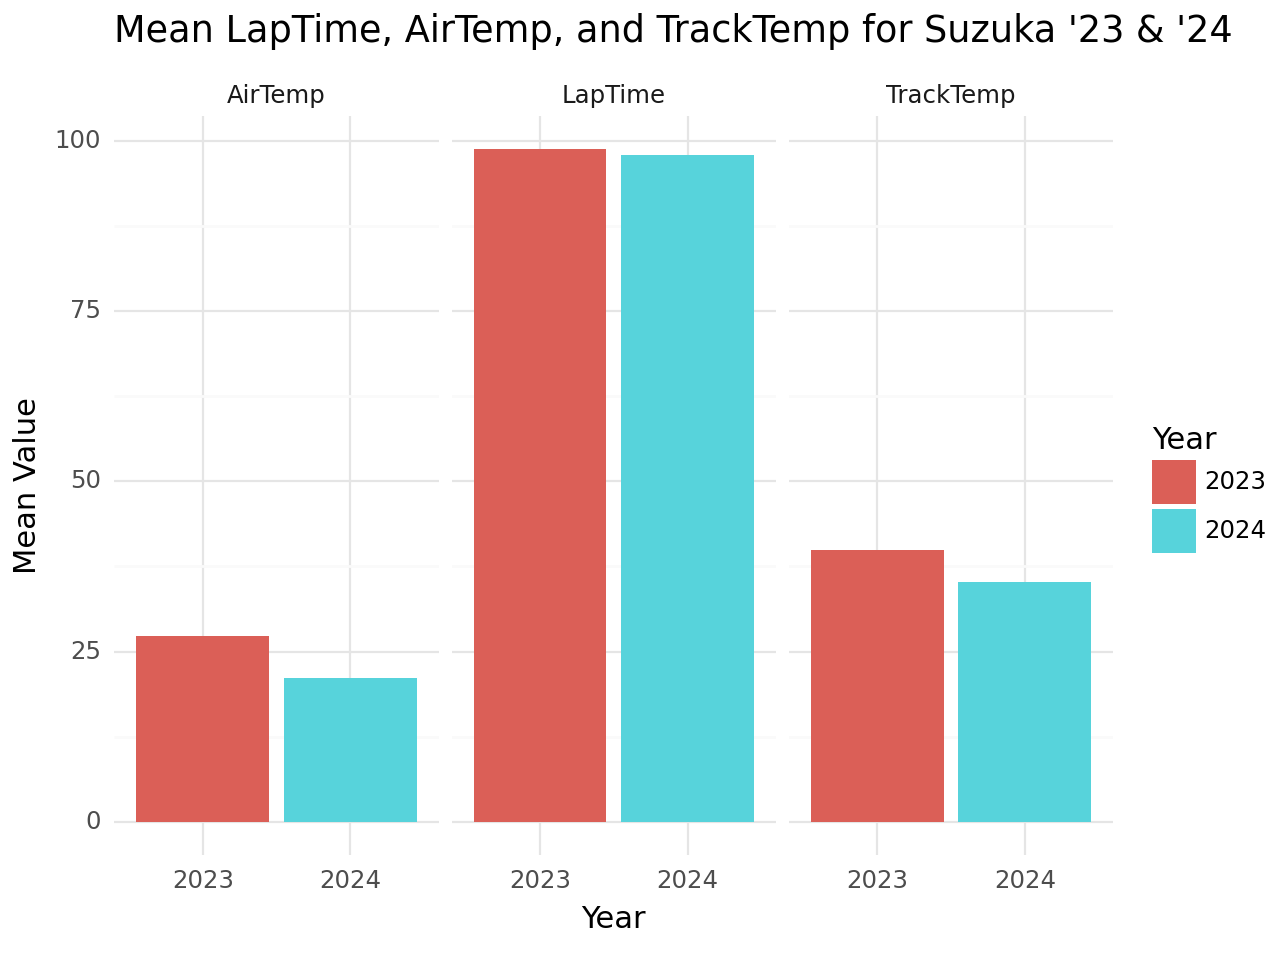

<Figure Size: (640 x 480)>

In [146]:
mean_values_2023 = japanese_gp_2023.describe().loc['mean', ['LapTime', 'AirTemp', 'TrackTemp']]
mean_values_2024 = japanese_gp_2024.describe().loc['mean', ['LapTime', 'AirTemp', 'TrackTemp']]

mean_df = pd.DataFrame({
    'Metric': ['LapTime', 'AirTemp', 'TrackTemp'] * 2,
    'Year': ['2023'] * 3 + ['2024'] * 3,
    'Mean': list(mean_values_2023) + list(mean_values_2024)
})

#https://ggplot2.tidyverse.org/reference/geom_bar.html
#https://ggplot2.tidyverse.org/reference/layer_positions.html
(ggplot(mean_df, aes(x='Year', y='Mean', fill='Year'))
+ geom_bar(stat='identity', position='dodge')
+ facet_wrap('Metric')
+ theme_minimal()
+ labs(title='Mean LapTime, AirTemp, and TrackTemp for Suzuka \'23 & \'24',
        x='Year', y='Mean Value'))

##Pre-Processing and Formatting

In [123]:
japanese_gp_2023 = japanese_gp_2023_copy
japanese_gp_2024 = japanese_gp_2024_copy

#Separate Data into predictors and outcome
predictors = ['Time', 'Driver', 'DriverNumber', 'LapNumber', 'Stint',
              'Sector1Time', 'Sector2Time', 'Sector3Time','SpeedI1', 'SpeedI2',
              'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife',
              'FreshTyre', 'Team', 'TrackStatus', 'Position',
              'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
              'WindDirection', 'WindSpeed']

continuous = ['Sector1Time','Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1',
              'SpeedI2','SpeedFL', 'SpeedST','TyreLife','AirTemp', 'Humidity',
              'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']

categorical = ['Time','Driver','DriverNumber','LapNumber','Stint','IsPersonalBest',
               'Compound','FreshTyre','Team','TrackStatus','Position']
outcome = ['LapTime']

x = japanese_gp_2023[predictors]

y_2023 = japanese_gp_2023[outcome]
y_2024 = japanese_gp_2024[outcome]

In [124]:
pre = make_column_transformer((StandardScaler(), continuous),                      #z-scoring for continuous
                            (OneHotEncoder(handle_unknown='ignore'), categorical), #One-Hot-Encoding for categorical
                            remainder = 'passthrough')
#Note: The 'handle_unknown' parameter allows me extrapolate! Surprsingly, extrapolating works!

#Linear Regression
lr = LinearRegression()

pipe = Pipeline([('pre', pre), ('linear', lr)])

#Fit
pipe.fit(x, y_2023)

y_pred_2023 = pipe.predict(japanese_gp_2023[predictors])
y_pred_2024 = pipe.predict(japanese_gp_2024[predictors])


print('Train MSE  : ', mean_squared_error(y_2023,y_pred_2023))
print('Train MAE  : ', mean_absolute_error(y_2023,y_pred_2023))
print('Train MAPE : ', mean_absolute_percentage_error(y_2023,y_pred_2023))
print('Train R2  : ', r2_score(y_2023,y_pred_2023))
print()
print('Test MSE  : ', mean_squared_error(y_2024,y_pred_2024))
print('Test MAE  : ', mean_absolute_error(y_2024,y_pred_2024))
print('Test MAPE : ', mean_absolute_percentage_error(y_2024,y_pred_2024))
print('Test R2  : ', r2_score(y_2024,y_pred_2024))

Train MSE  :  9.24890541776849e-11
Train MAE  :  7.640473423415946e-06
Train MAPE :  7.722713625006928e-08
Train R2  :  0.9999999999671673

Test MSE  :  0.0011828715739081108
Test MAE  :  0.023699127591595464
Test MAPE :  0.00023986268972415556
Test R2  :  0.999938594903639


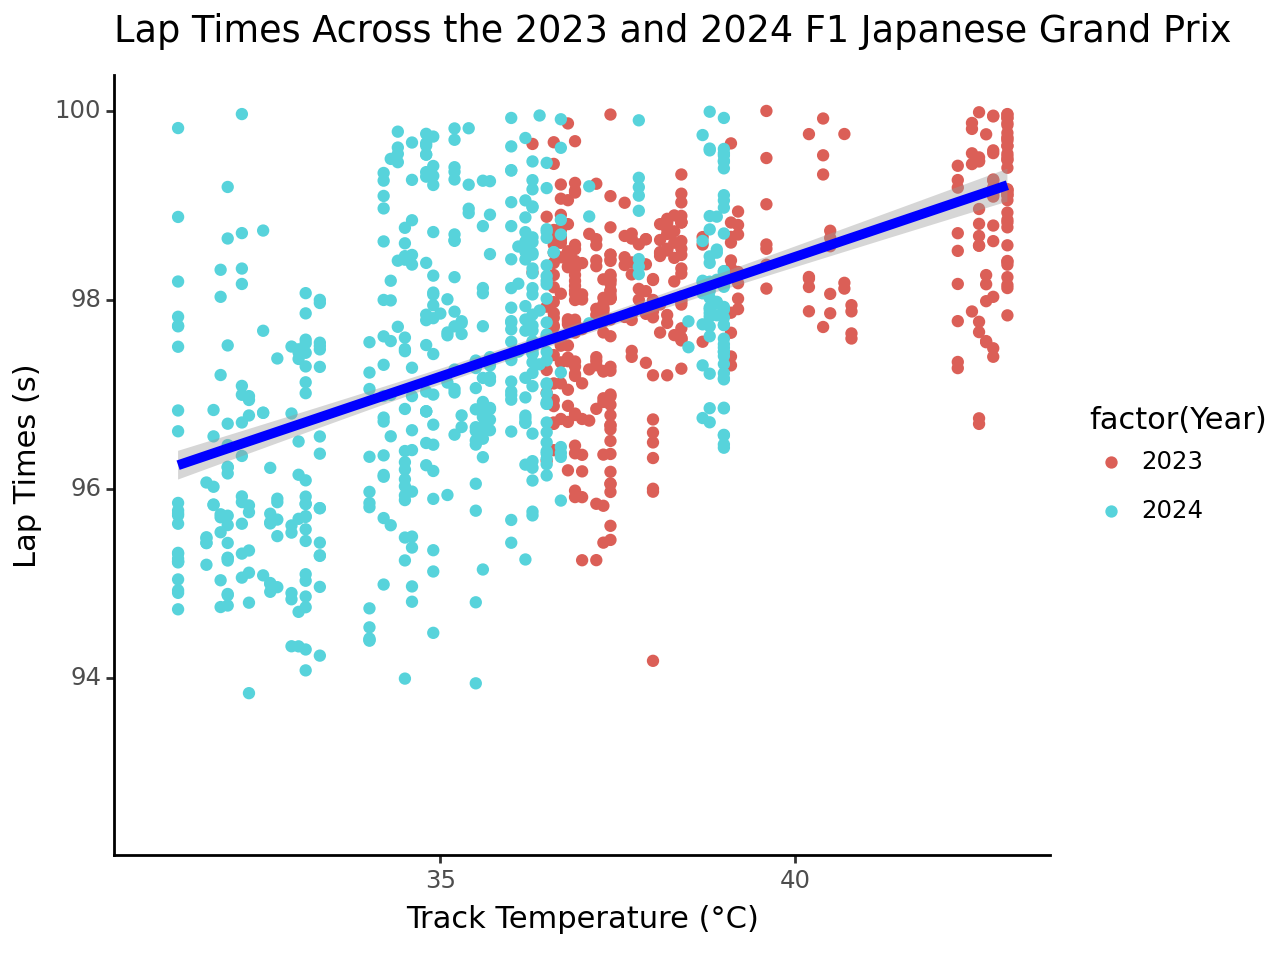

<Figure Size: (640 x 480)>

In [105]:
japanese_gp = pd.concat([japanese_gp_2023, japanese_gp_2024])
(ggplot(japanese_gp, aes(x='TrackTemp', y='LapTime', color = 'factor(Year)')) +
 geom_point() +
  labs(title = 'Lap Times Across the 2023 and 2024 F1 Japanese Grand Prix',
      x = 'Track Temperature (°C)',
      y = 'Lap Times (s)') +
 geom_smooth(method = 'lm', se = True, color = 'blue', size = 2) +
 xlim(31,43) +
 ylim(92.5,100) +
 theme_classic())

#Question 2
Can we find other tracks to similar to Suzuka that we can use to predict performance for the race in 2024?

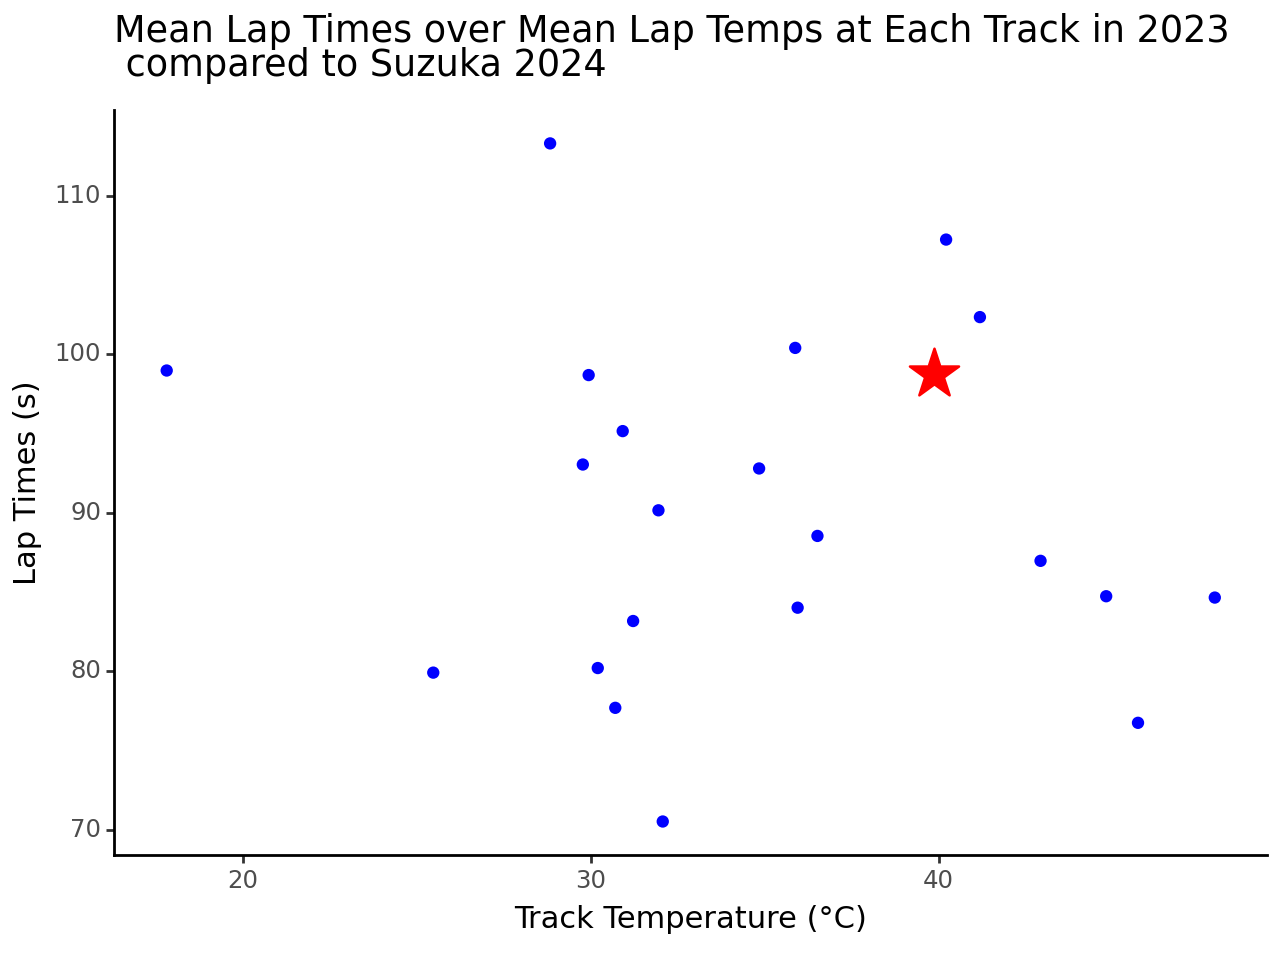

<Figure Size: (640 x 480)>

In [153]:
(ggplot(tracks, aes(x = 'TrackTemp_mean', y = 'LapTime_mean')) +
 geom_point(color='blue') +
 geom_point(data=tracks[tracks['Event'] == 'Japanese Grand Prix'], color='red', size=10, shape='*') + \
 theme_classic() +
 labs(title = 'Mean Lap Times over Mean Lap Temps at Each Track in 2023 \n compared to Suzuka 2024',
      x = 'Track Temperature (°C)',
      y = 'Lap Times (s)'))

In [155]:
predictors = ['LapTime_mean', 'Sector1Time_mean', 'Sector2Time_mean',
              'Sector3Time_mean', 'SpeedI1_mean', 'SpeedI2_mean', 'SpeedFL_mean',
              'SpeedST_mean', 'TyreLife_mean', 'AirTemp_mean', 'Humidity_mean',
              'Pressure_mean', 'Rainfall_mean', 'TrackTemp_mean',
              'WindDirection_mean', 'WindSpeed_mean', 'LapTime_median',
              'Sector1Time_median', 'Sector2Time_median', 'Sector3Time_median',
              'SpeedI1_median', 'SpeedI2_median', 'SpeedFL_median', 'SpeedST_median',
              'TyreLife_median', 'AirTemp_median', 'Humidity_median',
              'Pressure_median', 'Rainfall_median', 'TrackTemp_median',
              'WindDirection_median', 'WindSpeed_median', 'LapTime_min',
              'Sector1Time_min', 'Sector2Time_min', 'Sector3Time_min', 'SpeedI1_min',
              'SpeedI2_min', 'SpeedFL_min', 'SpeedST_min', 'TyreLife_min',
              'AirTemp_min', 'Humidity_min', 'Pressure_min', 'Rainfall_min',
              'TrackTemp_min', 'WindDirection_min', 'WindSpeed_min', 'LapTime_max',
              'Sector1Time_max', 'Sector2Time_max', 'Sector3Time_max', 'SpeedI1_max',
              'SpeedI2_max', 'SpeedFL_max', 'SpeedST_max', 'TyreLife_max',
              'AirTemp_max', 'Humidity_max', 'Pressure_max', 'Rainfall_max',
              'TrackTemp_max', 'WindDirection_max', 'WindSpeed_max', 'LapTime_std',
              'Sector1Time_std', 'Sector2Time_std', 'Sector3Time_std', 'SpeedI1_std',
              'SpeedI2_std', 'SpeedFL_std', 'SpeedST_std', 'TyreLife_std',
              'AirTemp_std', 'Humidity_std', 'Pressure_std', 'Rainfall_std',
              'TrackTemp_std', 'WindDirection_std', 'WindSpeed_std']
x = tracks[predictors]

z = make_column_transformer((StandardScaler(), predictors),
                            remainder = 'passthrough')

In [156]:
nn = NearestNeighbors(n_neighbors= 1)
pipe = Pipeline([('z', z), ('model', nn)])
pipe.fit(tracks[predictors])

distances, neighbors = pipe.named_steps['model'].kneighbors(pipe.named_steps['z'].transform(suzuka_2024[predictors]))

In [160]:
suzuka_2024 = suzuka_2024.assign(neighbors = list(neighbors))

#Assigning the closest neighbor
neighbor_name = tracks.iloc[neighbors[0]]['Event'].tolist()[0]
neighbor_name

'British Grand Prix'

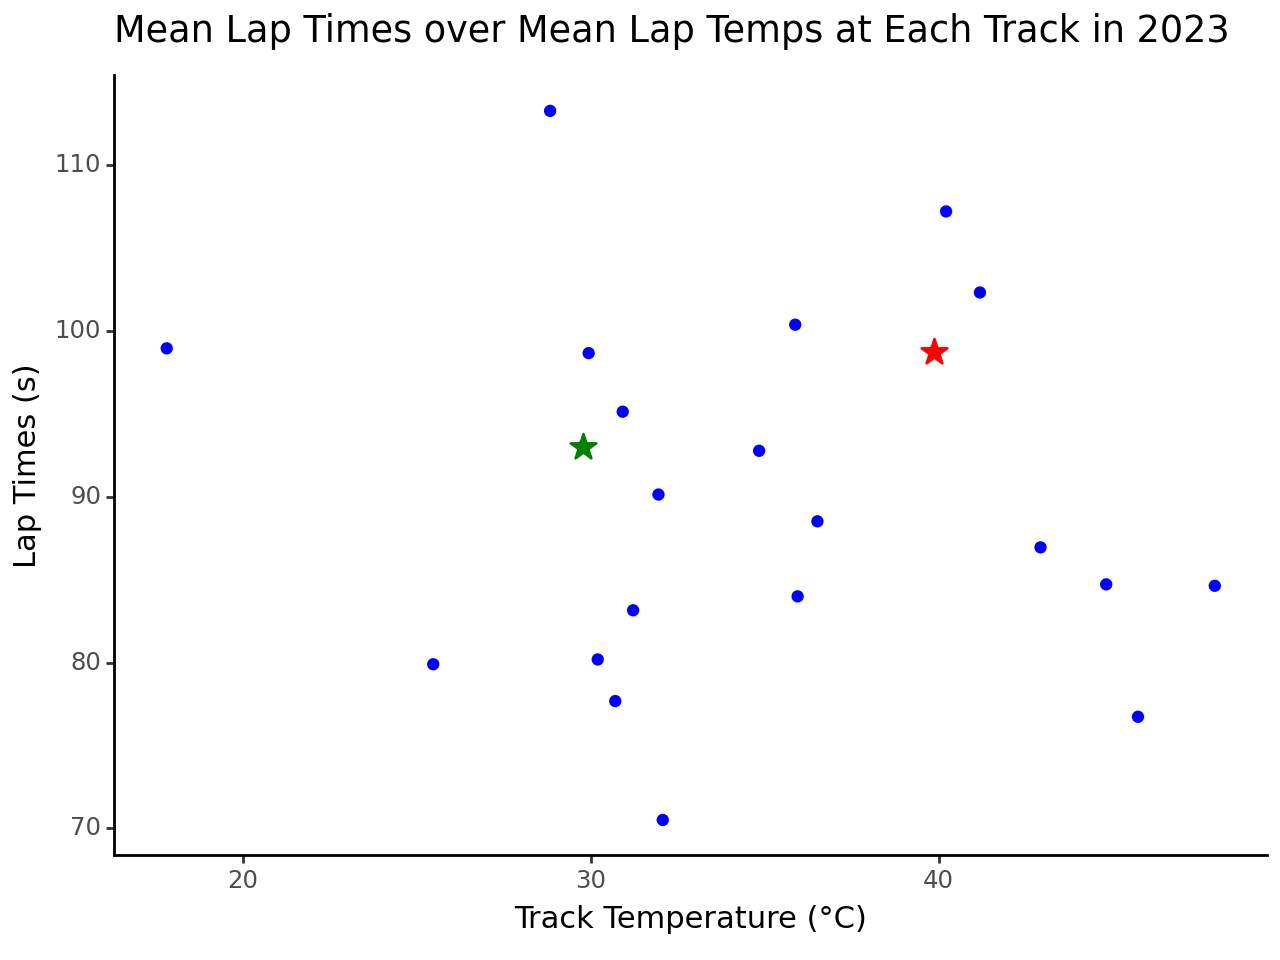

<Figure Size: (640 x 480)>

In [161]:
(ggplot(tracks, aes(x = 'TrackTemp_mean', y = 'LapTime_mean', color = 'factor(Event)')) +
 geom_point(color='blue') +
 geom_point(data=tracks[tracks['Event'] == 'Japanese Grand Prix'], color='red', size=5, shape='*') +
 geom_point(data=tracks[tracks['Event'] == neighbor_name], color='green', size=5, shape='*') +
 theme_classic() +
 labs(title = 'Mean Lap Times over Mean Lap Temps at Each Track in 2023',
      x = 'Track Temperature (°C)',
      y = 'Lap Times (s)'))

Training the model from Q1 using the nearest neighbor to Suzuka 2024

In [162]:
races_data = races_data_copy
neighbor_data = races_data[races_data['Event'] == neighbor_name]
japanese_gp_2024 = japanese_gp_2024_copy

predictors = ['Time', 'Driver', 'DriverNumber', 'LapNumber', 'Stint',
              'Sector1Time', 'Sector2Time', 'Sector3Time','SpeedI1', 'SpeedI2',
              'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife',
              'FreshTyre', 'Team', 'TrackStatus', 'Position',
              'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
              'WindDirection', 'WindSpeed']

continuous = ['Sector1Time','Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1',
              'SpeedI2','SpeedFL', 'SpeedST','TyreLife','AirTemp', 'Humidity',
              'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']

categorical = ['Time','Driver','DriverNumber','LapNumber','Stint','IsPersonalBest',
               'Compound','FreshTyre','Team','TrackStatus','Position']
outcome = ['LapTime']

x = neighbor_data[predictors]

y_2023 = neighbor_data[outcome]
y_2024 = japanese_gp_2024[outcome]

In [113]:
print(neighbor_data.columns == japanese_gp_2024.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]


In [114]:
neighbor_data['LapNumber'].unique()

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 14., 16.,
       17., 18., 24., 25., 26., 27., 28., 29., 30., 39., 40., 41., 43.,
       45., 46., 47., 49., 15., 19., 20., 22., 23., 44., 13., 21., 31.,
       42., 48., 52., 51., 50., 32.])

In [115]:
japanese_gp_2024['LapNumber'].unique()

array([ 4.,  5.,  6., 10., 11., 12., 18., 19., 20., 21., 24., 25., 27.,
       32., 37., 42., 43., 51., 53.,  7.,  8.,  9., 13., 14., 17., 22.,
       23., 26., 28., 29., 31., 35., 36., 38., 39., 40., 41., 44., 45.,
       49., 50., 52., 30., 33., 34., 46., 47., 48., 15., 16.,  3.])

In [163]:
#Empty Model
pre = make_column_transformer((StandardScaler(), continuous),
                            (OneHotEncoder(handle_unknown='ignore'), categorical),
                            remainder = 'passthrough')

#Linear Regression
lr = LinearRegression()

pipe = Pipeline([('pre', pre), ('linear', lr)])

#Fit
pipe.fit(x, y_neighbor)

y_neighbor_pred = pipe.predict(neighbor_data[predictors])
y_pred = pipe.predict(japanese_gp_2024[predictors])

print('Train MSE  : ', mean_squared_error(y_neighbor,y_neighbor_pred))
print('Train MAE  : ', mean_absolute_error(y_neighbor,y_neighbor_pred))
print('Train MAPE : ', mean_absolute_percentage_error(y_neighbor,y_neighbor_pred))
print('Train R2  : ', r2_score(y_neighbor,y_neighbor_pred))
print()
print('Test MSE  : ', mean_squared_error(y_2024,y_pred))
print('Test MAE  : ', mean_absolute_error(y_2024,y_pred))
print('Test MAPE : ', mean_absolute_percentage_error(y_2024,y_pred))
print('Test R2  : ', r2_score(y_2024,y_pred))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

#Question 3
Does weather really play as big of a factor as other features such as drivers, cars, teams etc.?

We run a Lasso Regression Model to answer this

In [ ]:
japanese_gp_2023 = japanese_gp_2023_copy
japanese_gp_2024 = japanese_gp_2024_copy

#Empty Model
pre = make_column_transformer((StandardScaler(), continuous),
                            (OneHotEncoder(handle_unknown='ignore'), categorical),
                            remainder = 'passthrough')

#Linear Regression
lasso = LassoCV()

pipe = Pipeline([('pre', pre), ('lasso', lasso)])

#Fit
pipe.fit(x, y_2023)

y_pred_2023 = pipe.predict(japanese_gp_2023[predictors])
y_pred_2024 = pipe.predict(japanese_gp_2024[predictors])


print('Train MSE  : ', mean_squared_error(y_2023,y_pred_2023))
print('Train MAE  : ', mean_absolute_error(y_2023,y_pred_2023))
print('Train MAPE : ', mean_absolute_percentage_error(y_2023,y_pred_2023))
print('Train R2  : ', r2_score(y_2023,y_pred_2023))
print()
print('Test MSE  : ', mean_squared_error(y_2024,y_pred_2024))
print('Test MAE  : ', mean_absolute_error(y_2024,y_pred_2024))
print('Test MAPE : ', mean_absolute_percentage_error(y_2024,y_pred_2024))
print('Test R2  : ', r2_score(y_2024,y_pred_2024))

In [ ]:
pipe.named_steps['lasso'].alpha_

In [ ]:
penalties = pipe.named_steps['lasso'].coef_

In [ ]:
d = {}
for i in range(26):
  d[predictors[i]] = penalties[i]
coefficients = pd.DataFrame(list(d.items()), columns=['Predictor', 'Coefficient'])
coefficients.head()

In [ ]:
#https://stackoverflow.com/questions/25664007/reorder-bars-in-geom-bar-ggplot2-by-value
(ggplot(coefficients, aes(x='reorder(Predictor, Coefficient)', y='Coefficient')) +
 geom_bar(stat='identity', fill='skyblue') +
 coord_flip() +
 theme_classic() +
 labs(title='Lasso Regression Coefficients',
      x='Predictor',
      y='Coefficient'))